In [11]:
import jax.numpy as jnp # transfer the backend from numpy to jax for GPU acceleration
import matplotlib.pyplot as plt

In [12]:
# LBM D2Q9 lattice scheme configuration
##############
#  6   2   5
#   \  |  /
# 3 —— 0 —— 1
#   /  |  \
#  7   4   8
##############

Nq = 9  # Number of lattice directions
Nx = 32  # Number of grid points in x-direction
Ny = 32  # Number of grid points in y-direction
Nt = 100  # Number of timesteps

# Lattice vector definition
ei = jnp.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
ci = jnp.array([[0, 1, 0, -1, 0, 1, -1, -1, 1], 
               [0, 0, 1, 0, -1, 1, 1, -1, -1]])

# Lattice weights definition
omega1, omega2, omega3 = 1.0, 1.5, 1.9
weights = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

In [13]:
# Meshgrid definition in 2D XY domain
t = jnp.arange(Nt)
xm = jnp.arange(Nx)
ym = jnp.arange(Ny)
X, Y = jnp.meshgrid(xm, ym, indexing='ij')

In [14]:
# fi field initialization
A_x = 0.3
k_x = 1

fi = jnp.zeros((Nx, Ny, Nq))
for i, wi in zip(ei, weights):
    fi = fi.at[X, Y, i].set(wi * (1 + A_x * jnp.cos(2 * jnp.pi * k_x * Y / Ny) * ci[0][i]))

fi1, fi2, fi3 = fi, fi, fi
g_jk = jnp.tensordot(fi, fi, axes=0)
g_jk1, g_jk2, g_jk3 = g_jk, g_jk, g_jk

In [15]:
def streaming(fi, g_jk):
    for i in ei:
        # Propagate fi value in each corresponding direction using jnp.roll
        fi = fi.at[:, :, i].set(jnp.roll(fi[:, :, i], ci[0][i], axis=0)) # roll along x
        fi = fi.at[:, :, i].set(jnp.roll(fi[:, :, i], ci[1][i], axis=1)) # roll along y

    for j in ei:
        g_jk = g_jk.at[:, :, j, :, :, :].set(jnp.roll(g_jk[:, :, j, :, :, :], ci[0][j], axis=0))
        g_jk = g_jk.at[:, :, j, :, :, :].set(jnp.roll(g_jk[:, :, j, :, :, :], ci[1][j], axis=1))

    for k in ei:
        g_jk = g_jk.at[:, :, :, :, :, k].set(jnp.roll(g_jk[:, :, :, :, :, k], ci[0][k], axis=3))
        g_jk = g_jk.at[:, :, :, :, :, k].set(jnp.roll(g_jk[:, :, :, :, :, k], ci[1][k], axis=4))

    return fi, g_jk

In [16]:
def get_matrix(omega):
    # Calculate matrix A
    ci_cj = jnp.tensordot(ci[0], ci[0], axes=0) + jnp.tensordot(ci[1], ci[1], axes=0) # ci is equivalent to cj
    L_ij = jnp.transpose(weights * (1 + 3 * ci_cj))
    A_ij = (1 - omega) * jnp.eye(Nq) + omega * L_ij

    # Calculate matrix B
    Q_ijk = jnp.zeros((Nq, Nq, Nq))
    for i in range(Nq):
        for j in range(Nq):
            for k in range(Nq):
                ci_cj = ci[0][i] * ci[0][j] + ci[1][i] * ci[1][j]
                ci_ck = ci[0][i] * ci[0][k] + ci[1][i] * ci[1][k]
                cj_ck = ci[0][j] * ci[0][k] + ci[1][j] * ci[1][k]
                Q_ijk = Q_ijk.at[i, j, k].set(9 * weights[i] * (ci_cj * ci_ck - cj_ck / 3))
    B_ijk = omega * Q_ijk
    
    return A_ij, B_ijk

In [17]:
def collision_BGK_2nd_carleman(fi_pre, A_ij, g_jk, B_ijk):
    f_j = jnp.squeeze(fi_pre)
    A_i = jnp.einsum('ij,NMj->NMi', A_ij, f_j) # N stands for x direction and M for y
    
    g_jk_dia = g_jk[X, Y, :, X, Y, :]
    
    B_i = jnp.einsum('ijk,NMjk->NMi', B_ijk, g_jk_dia)
    fi_collisioned = A_i + B_i
    
    AA = jnp.tensordot(A_ij, A_ij, axes=0)
    g_jk_collisioned = jnp.einsum('ikjl,NMkXYl->NMiXYj', AA, g_jk)
    
    return fi_collisioned, g_jk_collisioned

In [18]:
def get_macro_quantities(fi):
    rho = jnp.sum(fi, axis=2)  # Density
    ux = jnp.sum(fi * ci[0], 2) / rho
    uy = jnp.sum(fi * ci[1], 2) / rho
    
    return rho, ux, uy

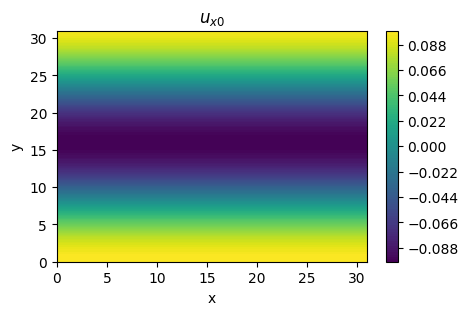

In [21]:
_, ux0, uy0 = get_macro_quantities(fi)
u0 = jnp.sqrt(ux0**2 + uy0**2)

plt.figure(figsize=(5, 3))
contour = plt.contourf(X, Y, ux0, levels=100, cmap='viridis', vmin=-0.1, vmax=0.1)
plt.colorbar(contour)
plt.title("$u_{x0}$")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [20]:
step = 0
fi1s, u1s = [], []
A_ij1, B_ijk1 = get_matrix(omega1)
for i in range(Nt):
    fi1s.append(fi1)
    _, ux1, uy1 = get_macro_quantities(fi1)
    ui = jnp.sqrt(ux1**2 + uy1**2)
    u1 = ui[16, 16] / u0[16, 16]
    u1s.append(u1)
    
    fi1, g_jk1 = collision_BGK_2nd_carleman(fi1, A_ij1, g_jk1, B_ijk1)
    fi1, g_jk1 = streaming(fi1, g_jk1)
    
    print(step)
    step += 1
    

fi2s, u2s = [], []
A_ij2, B_ijk2 = get_matrix(omega2)
for i in range(Nt):
    fi2s.append(fi2)
    _, ux2, uy2 = get_macro_quantities(fi2)
    ui = jnp.sqrt(ux2**2 + uy2**2)
    u2 = ui[16, 16] / u0[16, 16]
    u2s.append(u2)
    
    fi2, g_jk2 = collision_BGK_2nd_carleman(fi2, A_ij2, g_jk2, B_ijk2)
    fi2, g_jk2 = streaming(fi2, g_jk2)
    
    print(step)
    step += 1
    

fi3s, u3s = [], []
A_ij3, B_ijk3 = get_matrix(omega3)
for i in range(Nt):
    fi3s.append(fi3)
    _, ux3, uy3 = get_macro_quantities(fi3)
    ui = jnp.sqrt(ux3**2 + uy3**2)
    u3 = ui[16, 16] / u0[16, 16]
    u3s.append(u3)
    
    fi3, g_jk3 = collision_BGK_2nd_carleman(fi3, A_ij3, g_jk3, B_ijk3)
    fi3, g_jk3 = streaming(fi3, g_jk3)
    
    print(step)
    step += 1

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(t, u1s, label="$\\omega = 1.0$", color="green")
plt.plot(t, u2s, label="$\\omega = 1.5$", color="red")
plt.plot(t, u3s, label="$\\omega = 1.9$", color="blue")
plt.xlabel("t")
plt.yscale("log")
plt.ylabel("$u_x/u_{x0}$")
plt.grid(True)
plt.legend()
plt.savefig("ux_evolution_CLLBM.pdf", format='pdf')  # Vector export
plt.show()

In [ ]:
fi_all = jnp.stack((fi1s, fi2s, fi3s), axis=0)
jnp.save("fi_2nd carleman_x.npy", fi_all)